# Initialize

In [22]:
%load_ext autoreload
%autoreload 2

#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn

from AE.models import AE_0
from AE.datasets import MNISTDigit2Dataset

from AE.depth_utils import get_KL_with_HFM_with_optimal_g
from AE.depth_utils import plot_KLs_vs_hidden_layers, datasets_dicts_comparison

#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Utilizzo Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Utilizzo NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Utilizzo la CPU")

device = torch.device("cpu")  # Fallback to CPU if no GPU is available

SEED = 42
torch.manual_seed(SEED)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Utilizzo Apple Silicon GPU (MPS)



# Datasets


In [2]:
batch_size = 64

## MNIST
train_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



## ExtendedMNIST

train_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )


## 2MNIST

dataset_2MNIST_train = MNISTDigit2Dataset(train=True, download=True, target_size=60000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
train_loader_2MNIST = DataLoader(dataset_2MNIST_train, batch_size=batch_size, shuffle=True)

batch_images, batch_labels = next(iter(train_loader_2MNIST))
print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")

print("\n––––––––––––––––––––––––––––––––––––––––––––––––––––––\n")

dataset_2MNIST_val = MNISTDigit2Dataset(train=False, download=True, target_size=10000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")
val_loader_2MNIST = DataLoader(dataset_2MNIST_val, batch_size=batch_size, shuffle=True)

print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")



## FashionMNIST

train_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



Found 5958 original samples of digit '2'
Generated 60000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
All labels are 2: True

––––––––––––––––––––––––––––––––––––––––––––––––––––––

Found 1032 original samples of digit '2'
Generated 10000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
All labels are 2: True
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
All labels are 2: True



## OTHERS


In [ ]:
from AE.datasets import Dataset_HFM, Dataset_pureHFM

batch_size = 64


## train over pureHFM

dataset_HFM_train = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_pureHFM = DataLoader(
    dataset_HFM_train,
    batch_size= batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_pureHFM = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size= batch_size,
    shuffle=False
)
## train over expandedHFM
dataset_HFM_train = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/16_1024features/2hl_glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_expandedHFM = DataLoader(
    dataset_HFM_train,
    batch_size= batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/16_1024features/2hl_glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_expandedHFM = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size= batch_size,
    shuffle=False
)
## train over expandedHFM 32-1024
dataset_HFM_train = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_train,
    batch_size= batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size= batch_size,
    shuffle=False
)


# Analysis

In [57]:
KLs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}

gs_dict = {
    '2MNIST': [],
    'MNIST': [],
    'EMNIST': []}  

# MNIST

In [61]:
train_loader = train_loader_MNIST
val_loader = val_loader_MNIST
input_dim = 28 * 28

In [62]:
KLs_dict["MNIST"] = []
gs_dict["MNIST"] = []

## 6 features

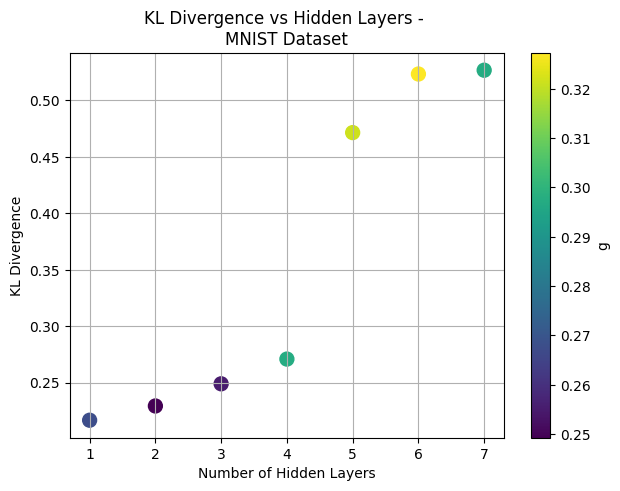

In [41]:
my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)



plot_KLs_vs_hidden_layers(KLs_dict["MNIST"], gs_dict["MNIST"], "MNIST")

## 8 features

### classical train

In [104]:
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_ep15_dr05_lr1e3_opeSigm_1hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)


my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_ep15_dr05_lr1e3_opeSigm_2hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)


my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_ep15_dr05_lr1e3_opeSigm_3hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)


my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_ep15_dr05_lr1e3_opeSigm_4hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

### layer-wise pretrain

In [5]:
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)


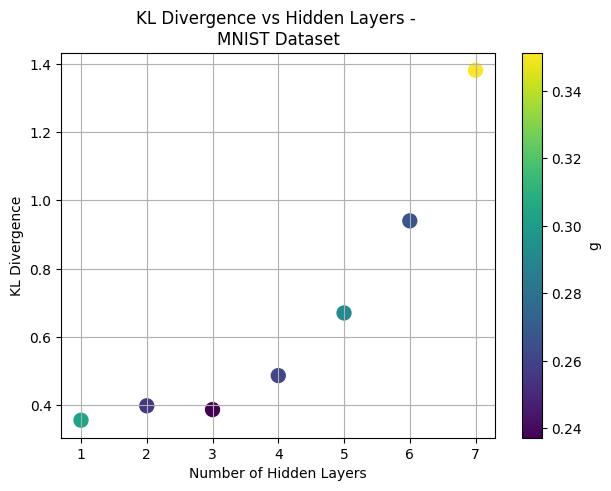

In [19]:
plot_KLs_vs_hidden_layers(KLs_dict["MNIST"], gs_dict["MNIST"], "MNIST")

## 10 features


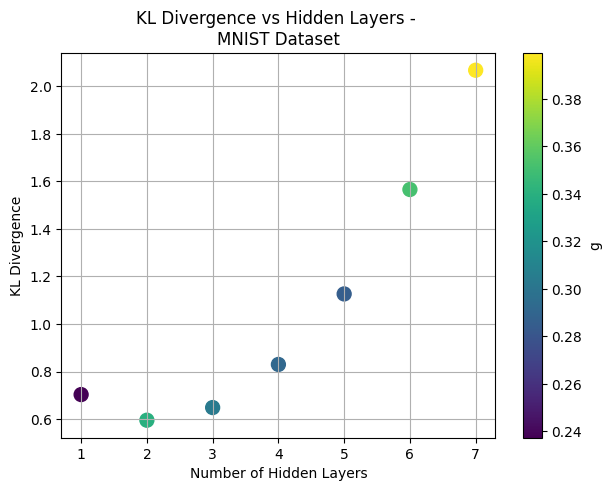

In [63]:
my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["MNIST"].append(KL)
gs_dict["MNIST"].append(g)

plot_KLs_vs_hidden_layers(KLs_dict["MNIST"], gs_dict["MNIST"], "MNIST")

# EMNIST

In [58]:
train_loader = train_loader_EMNIST
val_loader = val_loader_EMNIST
input_dim = 28 * 28

In [59]:
KLs_dict["EMNIST"] = []
gs_dict["EMNIST"] = []

## 6 features

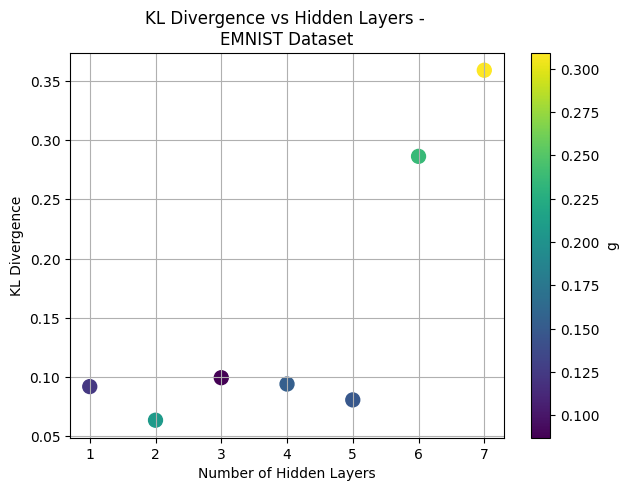

In [27]:
my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

plot_KLs_vs_hidden_layers(KLs_dict["EMNIST"], gs_dict["EMNIST"], "EMNIST")

## 8 features

### classical train

In [100]:
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_ep15_dr05_lr1e3_opeSigm_1hl.pth', map_location=device))
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_ep15_dr05_lr1e3_opeSigm_2hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_ep15_dr05_lr1e3_opeSigm_3hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_ep15_dr05_lr1e3_opeSigm_4hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)


### lw pretrain

In [9]:
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

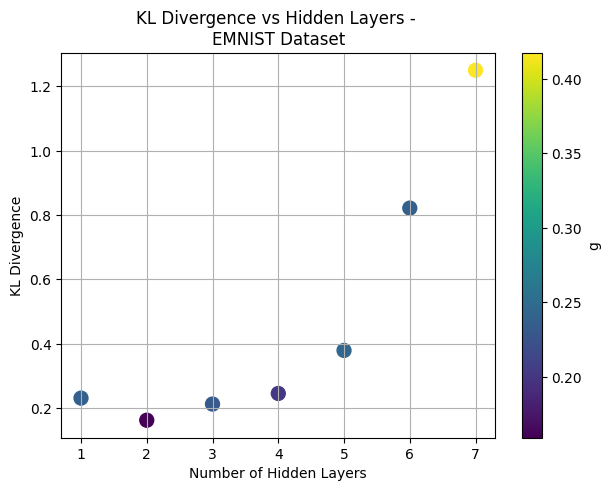

In [20]:
plot_KLs_vs_hidden_layers(KLs_dict["EMNIST"], gs_dict["EMNIST"], "EMNIST")

## 10 features


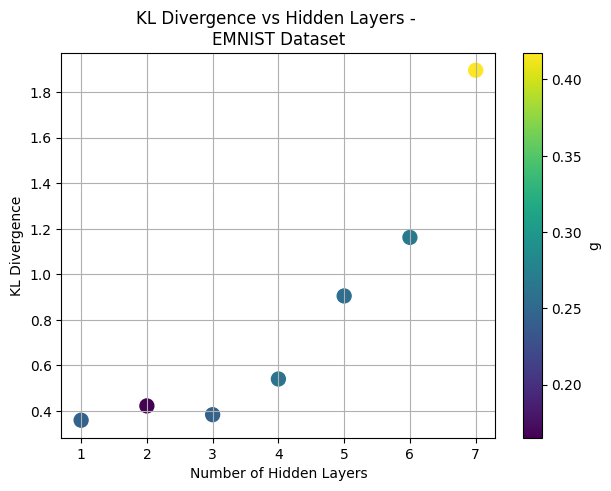

In [60]:
my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["EMNIST"].append(KL)
gs_dict["EMNIST"].append(g)

plot_KLs_vs_hidden_layers(KLs_dict["EMNIST"], gs_dict["EMNIST"], "EMNIST")

# 2MNIST

In [73]:
train_loader = train_loader_2MNIST
val_loader = val_loader_2MNIST
input_dim = 28 * 28

In [74]:
KLs_dict["2MNIST"] = []
gs_dict["2MNIST"] = []

## 6 features

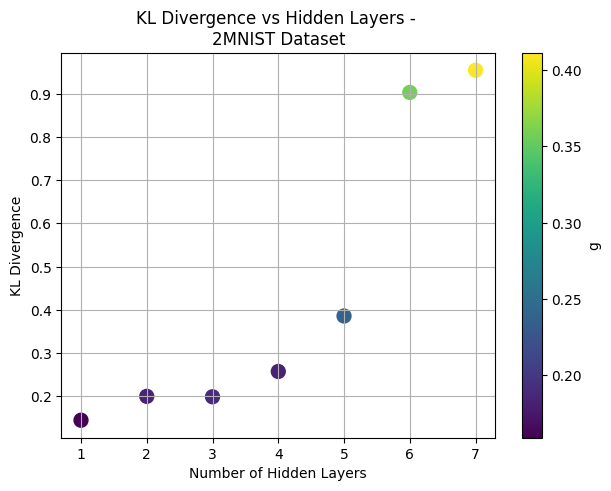

In [46]:
my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

plot_KLs_vs_hidden_layers(KLs_dict["2MNIST"], gs_dict["2MNIST"], "2MNIST")

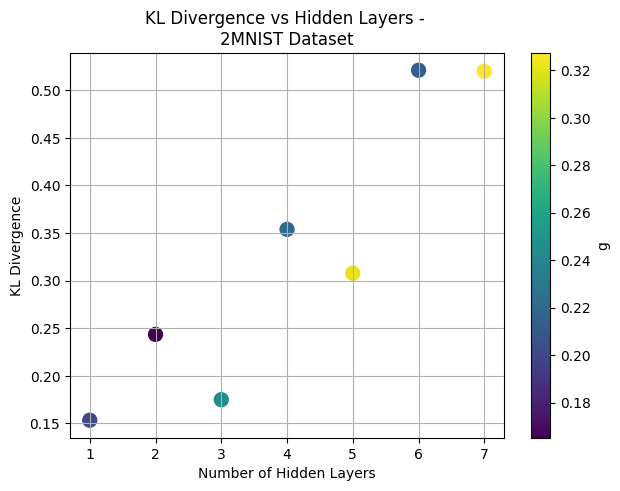

In [51]:
my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_1hl_1.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_2hl_1.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_3hl_1.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_4hl_1.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_5hl_1.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_6hl_1.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_7hl_1.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

plot_KLs_vs_hidden_layers(KLs_dict["2MNIST"], gs_dict["2MNIST"], "2MNIST")

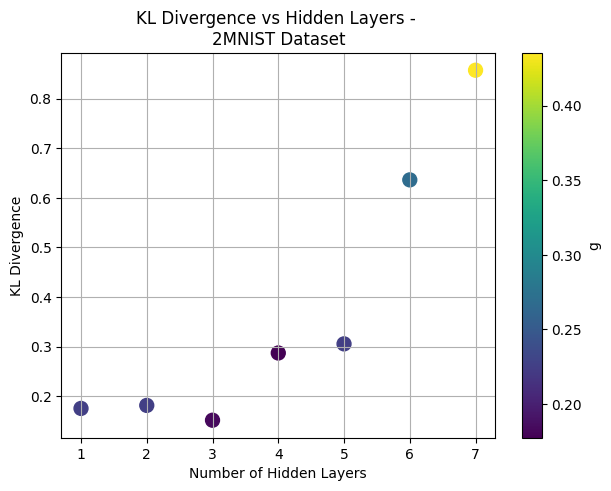

In [55]:
my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_1hl_2.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_2hl_2.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_3hl_2.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_4hl_2.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_5hl_2.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_6hl_2.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_7hl_2.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

plot_KLs_vs_hidden_layers(KLs_dict["2MNIST"], gs_dict["2MNIST"], "2MNIST")

## 8 features

### classical train

In [96]:
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_ep15_dr05_lr1e3_opeSigm_1hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_ep15_dr05_lr1e3_opeSigm_2hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_ep15_dr05_lr1e3_opeSigm_3hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_ep15_dr05_lr1e3_opeSigm_4hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)


### lw pretrain

In [15]:
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

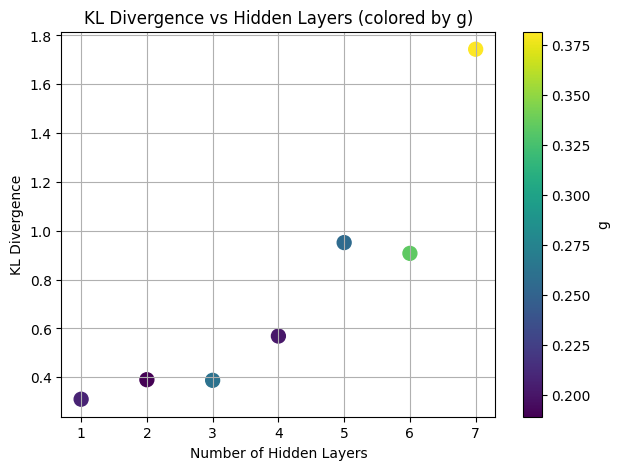

In [16]:
plot_KLs_vs_hidden_layers(KLs_dict["2MNIST"], gs_dict["2MNIST"])

## 10 features


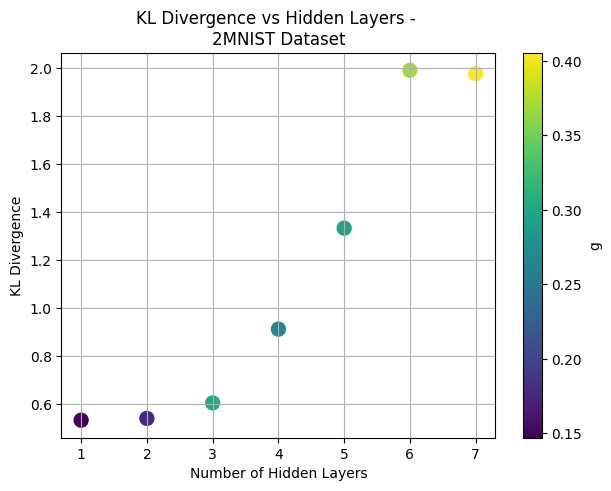

In [71]:
my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

plot_KLs_vs_hidden_layers(KLs_dict["2MNIST"], gs_dict["2MNIST"], "2MNIST")

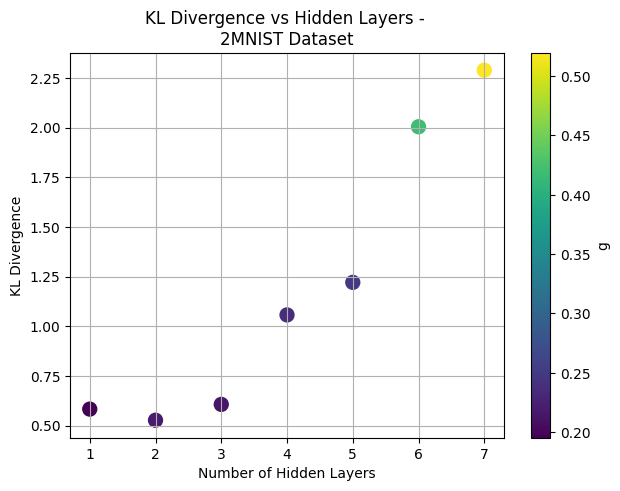

In [75]:
my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_1hl_1.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_2hl_1.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_3hl_1.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_4hl_1.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_5hl_1.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_6hl_1.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

my_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
my_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_7hl_1.pth', map_location=device))
KL, g = get_KL_with_HFM_with_optimal_g(my_model, train_loader, return_g=True)
KLs_dict["2MNIST"].append(KL)
gs_dict["2MNIST"].append(g)

plot_KLs_vs_hidden_layers(KLs_dict["2MNIST"], gs_dict["2MNIST"], "2MNIST")

# COMPARISONS

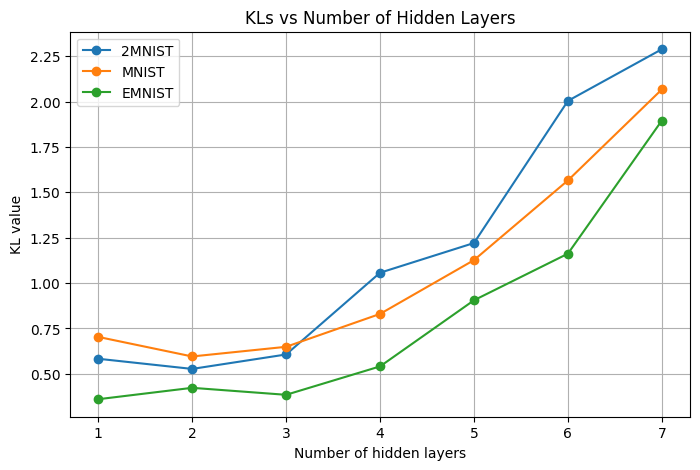

In [76]:
datasets_dicts_comparison(KLs_dict)

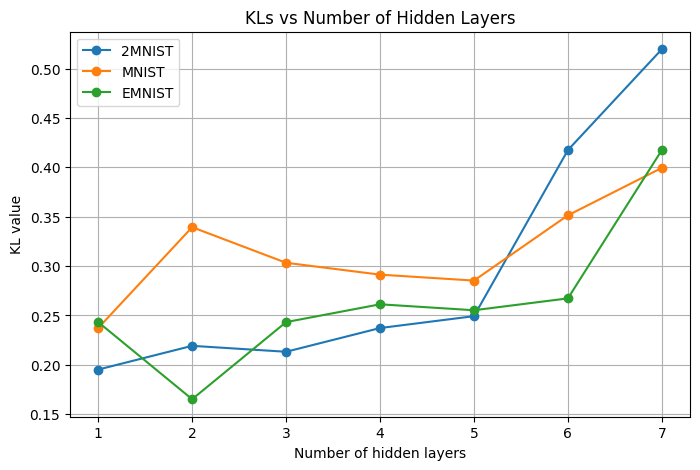

In [77]:

datasets_dicts_comparison(gs_dict)